<a href="https://colab.research.google.com/github/dyjdlopez/intro_2_quantum/blob/main/qiskit/01_03_oracle_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Quantum Aglorithms: Oracles
$_{\text{Made by: @dyjdlopez}}$


In this notebook, we explore **quantum oracle algorithms**—a class of quantum algorithms that demonstrate how quantum computation can extract global properties of a function more efficiently than any classical counterpart. By the end of this section, you should be able to:

- Understand what a **quantum oracle** is and how it represents a Boolean function.
- Explain how **phase kickback** encodes information from an oracle.
- Construct and simulate three foundational oracle algorithms:
  1. **Deutsch's Algorithm**: distinguishes between constant and balanced 1-bit functions.
  2. **Deutsch-Jozsa Algorithm**: generalizes Deutsch's idea to n-bit inputs.
  3. **Bernstein-Vazirani Algorithm**: discovers a hidden bit-string $s$ in a single query.
- Interpret measurement results and connect them to the theoretical expectations.

## Background

An **oracle** is a *black box* that computes a Boolean function  
$$
f:\{0,1\}^n \to \{0,1\}.
$$
The oracle operates as a quantum unitary transformation:
$$
U_f |x\rangle|y\rangle = |x\rangle |y \oplus f(x)\rangle,
$$
where $\oplus$ denotes XOR.

Quantum algorithms can query this oracle **in superposition**, enabling interference patterns that reveal global information about $f$ with fewer queries than classical methods.

These early oracle-based algorithms are conceptually simple yet historically significant, they were among the first to show a *provable* separation between classical and quantum computational capabilities. However, there are no seen practical applications for these algorithms but they are good pre-requisites for more power quantum algorithms.


In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=37f1f46286bc6d1722e5fb8a09b67658372df96c52b385b777b7c4d45db52e74
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.visualization import plot_bloch_vector, plot_histogram
from qiskit_aer import AerSimulator
from qiskit import transpile

## 1. What Are Query Gates?

In quantum algorithms, **query gates** (also called **oracles**) represent a *black-box function* that the quantum algorithm can access by asking questions. This section draws on the query-model description from IBM Quantum.

### 1.1 The Query Model

In the **query model of computation**, the full input is *not* provided explicitly; instead, the algorithm interacts with the input via a function $f$.
Concretely:  
$$
f: \{0,1\}^n \;\to\; \{0,1\}^m
$$
The algorithm selects an input string \(x \in \{0,1\}^n\) and then obtains $(x)$ via a query.

The cost of a query algorithm is typically measured by the **number of queries** (i.e., the number of times it accesses $f$).

### 1.2 Query Gates in Circuits

When we express the query model as a circuit, we use **query gates**, which are special gates representing one call to the black-box function.

For classical Boolean circuits, a query gate might directly compute $f(x)$. For quantum circuits, we need a *unitary* implementation of the oracle so that superpositions are preserved.  

A common quantum form of the query gate is:
$$
U_f \;:\; |x\rangle\,|y\rangle \;\mapsto\; |x\rangle\,|y \oplus f(x)\rangle
$$
Here:
- $|x\rangle$ is the input register (data qubits).
- $|y\rangle$ is an output/ancilla qubit (or register) that stores the result by XORing with $f(x)$.
- This unitary is its own inverse (a permutation matrix) and preserves quantum norm.

### 1.3 Why Query Gates Matter

- **Black-box access:** The algorithm cannot see the internal structure of $f$; it only receives values via queries.  
- **Superposition access:** Because the gate is unitary, we can apply it to superpositions of $|x\rangle$, enabling quantum algorithms to query **many inputs at once** and exploit interference.  
- **Query complexity:** By counting the number of query gates, we analyse the quantum vs classical advantage in the number of accesses needed.  
- **Model abstraction:** The query model hides the cost of building the oracle, the focus is on how many times it is used, not how complex it is.

## 2. Deutsch's Algorithm (n = 1)

### 2.1 Problem Statement  
Consider a function  
$$
f:\{0,1\} \;\to\; \{0,1\}
$$  
with the promise that $f$ is either **constant** (i.e., $f(0)=f(1)$) or **balanced** (i.e., $f(0)\neq f(1)$).  
A classical algorithm must evaluate $f$ **twice** (checking both inputs) in the worst case to decide which.  

The Deutsch algorithm allows us to decide *constant vs. balanced* with **one quantum query**.

### 2.2 Quantum Circuit  
The standard circuit uses two qubits: one data qubit and one ancilla. Overview:

1. $|\psi_0\rangle$: Initialize the input qubit in $|0\rangle$ and the ancilla qubit in $|1\rangle$.  
2. $|\psi_1\rangle$: Apply Hadamard gates to both qubits (to create a superposition and prepare for phase-kickback).  
3. $|\psi_2\rangle$: Call the oracle unitary $U_f: |x\rangle|y\rangle \mapsto |x\rangle|y \oplus f(x)\rangle$.  
4. $|\psi_3\rangle$: Apply Hadamard on the input qubit again.  
5. $P_{\text{deutsch}}$: Measure the input qubit.  

Statevector: Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))


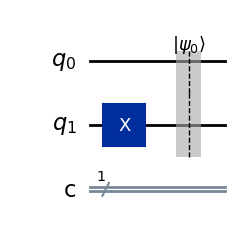

In [ ]:
# Step 1
num_qubits = 2
deutsch = QuantumCircuit(num_qubits, 1)

deutsch.x(1)
deutsch.barrier(label=r'$|\psi_0\rangle$')

state = Statevector.from_instruction(deutsch)
print("Statevector:", state)


deutsch.draw('mpl')

From the `StateVector` result, we validate that $|\psi_0\rangle = |0\rangle + |1\rangle$.

Statevector: Statevector([ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
            dims=(2, 2))


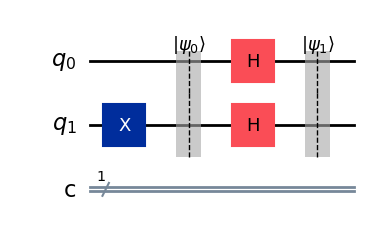

In [ ]:
# Step 2
deutsch.h([0,1])
deutsch.barrier(label=r'$|\psi_1\rangle$')

state = Statevector.from_instruction(deutsch)
print("Statevector:", state)


deutsch.draw('mpl')

Now we see that $|\psi_1\rangle = |-\rangle |+\rangle$. We validate that it is the superposition of two qubits if we check the amplitudes in the updated `StateVector`. We can also re-write it as:
$$|\psi_1\rangle = \frac{1}{2}\left(|0\rangle - |1\rangle\right)|0\rangle + \frac{1}{2}\left(|0\rangle - |1\rangle\right)|1\rangle$$
This will be handy for for validating the design of $|\psi_2\rangle$. We can now define our oracle unitary $U_f$. Our oracle can determine whether a function is *constant* or *balanced*.

For a one-bit input $ a \in \{0,1\} $, there are **four possible Boolean functions**.  
Each function $f_i(a) $ maps the inputs 0 and 1 to a binary output.

| **a** | **f₁(a)** | **f₂(a)** | **f₃(a)** | **f₄(a)** |
|:-----:|:----------:|:----------:|:----------:|:----------:|
| 0 | 0 | 0 | 1 | 1 |
| 1 | 0 | 1 | 0 | 1 |

---

### Classification

| Function | Expression | Type | Description |
|:---------:|:------------|:------|:-------------|
| $ f_1(a) $ | Constant 0 | Constant | Always outputs 0 |
| $ f_2(a) $ | Identity $f(a)=a$ | Balanced | $f(0)\neq f(1)$ |
| $ f_3(a) $ | NOT $f(a)=\bar{a}$ | Balanced | $f(0)\neq f(1)$ |
| $ f_4(a) $ | Constant 1 | Constant | Always outputs 1 |

> The Deutsch algorithm distinguishes between **constant** and **balanced** functions in just **one query**.

Statevector: Statevector([-0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j],
            dims=(2, 2))


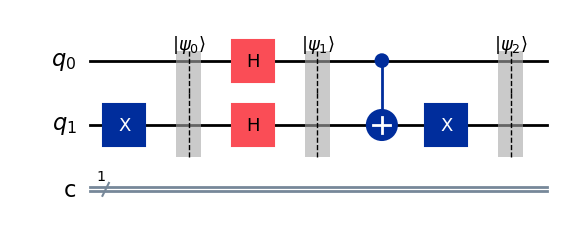

In [ ]:
# Step 3
deutsch.cx(0,1)
deutsch.x(1)
deutsch.barrier(label=r'$|\psi_2\rangle$')

state = Statevector.from_instruction(deutsch)
print("Statevector:", state)


deutsch.draw('mpl')

Let's examine how $U_f$ acts when the ancilla is in $|-\rangle$:

$$
\begin{align}
U_f \, |x\rangle|-\rangle
&= U_f \left(|x\rangle \frac{|0\rangle - |1\rangle}{\sqrt{2}}\right) \\[6pt]
&= \frac{1}{\sqrt{2}} \big(|x\rangle|f(x)\rangle - |x\rangle|1 \oplus f(x)\rangle\big)
\end{align}
$$

Notice that if $f(x)=0$, nothing changes, but if $f(x)=1$, the relative phase of the ancilla flips sign.  
The ancilla returns to $|-\rangle$, but the **sign of the whole term** is now multiplied by $(-1)^{f(x)}$:

$$
U_f \, |x\rangle|-\rangle = (-1)^{f(x)} |x\rangle|-\rangle
$$

Thus, the oracle's effect is transferredn or *kicked back* onto the **phase** of the first qubit.  
This is the **phase kickback effect**.

In circuit form, the oracle $U_f$ is built using **controlled gates** according to the definition of $f(a)$:  

| Function | Description | Oracle Design |
|:----------|:-------------|:---------------|
| $f_1$ | Constant-0 | Do nothing |
| $f_2$ | Identity | Apply `CX` from input to ancilla |
| $f_3$ | NOT | Apply `CX`, then `X` |
| $f_4$ | Constant-1 | Apply `X` on ancilla |


Statevector: Statevector([-5.97792087e-34+0.j, -6.22328532e-19+0.j, -3.25176795e-17+0.j,
             -1.00000000e+00+0.j],
            dims=(2, 2))


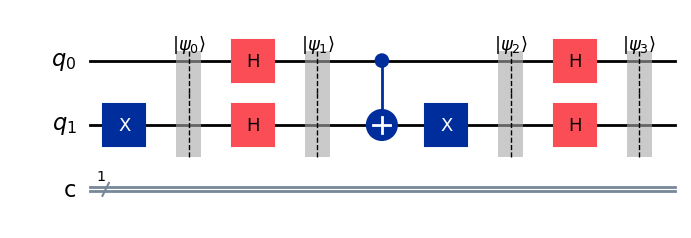

In [ ]:
# Step 3
deutsch.h([0,1])
deutsch.barrier(label=r'$|\psi_3\rangle$')

state = Statevector.from_instruction(deutsch)
print("Statevector:", state)


deutsch.draw('mpl')

The **final Hadamard gate** on the input qubit is the critical step that **translates this hidden phase information back into measurable amplitudes.**

After the oracle, and assuming the ancilla was prepared in $|-\rangle$,  
the two-qubit system is in the state:

$$
|\psi_{3}\rangle =  |-\rangle \otimes\frac{1}{\sqrt{2}} \Big[ (-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle \Big]
$$

Depending on whether $f$ is constant or balanced, this state has either **equal** or **opposite** phases on $|0\rangle$ and $|1\rangle$.
$$
|\psi_3\rangle =
\begin{cases}
(-1)^{f(0)} \, |-\rangle|0\rangle, & \text{if } f(0) \oplus f(1) = 0 \\[6pt]
(-1)^{f(0)} \, |-\rangle|1\rangle, & \text{if } f(0) \oplus f(1) = 1
\end{cases}
$$

This shows that:

- If $f(0) \oplus f(1) = 0$, the result is $|-\rangle|0\rangle$ → **constant**  
- If $f(0) \oplus f(1) = 1$, the result is $|-\rangle|1\rangle$ → **balanced**



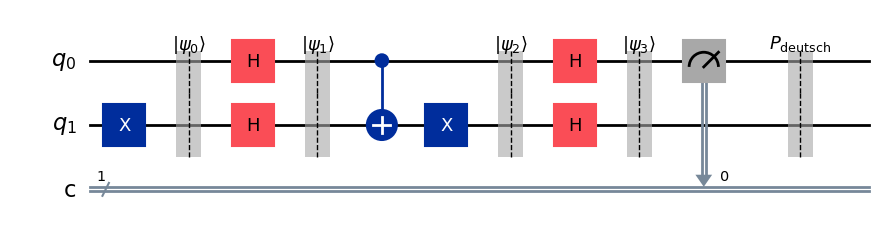

In [ ]:
# Step 4
deutsch.measure(0, 0)
deutsch.barrier(label=r'$P_{\text{deutsch}}$')

deutsch.draw('mpl')

In [ ]:
# Step 4
simulator = AerSimulator()

compiled_circuit = transpile(deutsch, simulator)
job = simulator.run(compiled_circuit, shots=1000)
result = job.result()
counts = result.get_counts()

if int(counts.most_frequent())==1:
  print('Equation is balanced.')
else:
  print('Equation is constant.')

Equation is balanced.


In [ ]:
## Now let's try to make a function of the Deutsch Algorithm to try different functions

def deutsch_algorthim(function_type):
  qc = QuantumCircuit(2, 1)
  qc.x(1)
  qc.barrier()
  qc.h([0,1])
  qc.barrier()


  ####### START CODING HERE ########
  '''
  EXERCISE 1

  Create the oracle U_f depending on the type of function `function_type` from
  the input parameter. You may use condition statements to apply different gates
  depending on the input.
  '''


  ####### DON'T EDIT BEYOND HERE ###

  qc.barrier()
  qc.h([0,1])
  qc.barrier()
  qc.measure(0,0)

  compiled_circuit = transpile(qc, simulator)
  job = simulator.run(compiled_circuit, shots=1000)
  result = job.result()
  counts = result.get_counts()

  if int(counts.most_frequent())==1:
    print('Equation is balanced.')
  else:
    print('Equation is constant.')

  return qc

Equation is constant.


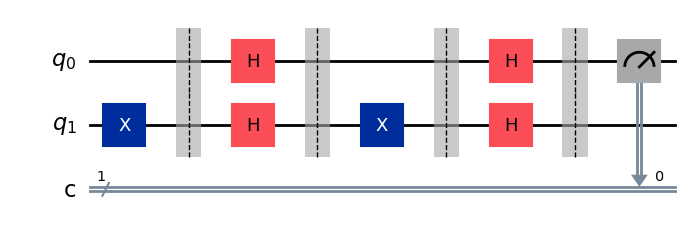

In [ ]:
## Example use and output

ckt = deutsch_algorthim('one')
ckt.draw('mpl')

## 3. Deutsch-Jozsa Algorithm


### 3.1 Problem (with Promise)

Given a black-box Boolean function
$$
f:\{0,1\}^n \to \{0,1\},
$$
promised to be **either**:
- **constant** (all outputs equal), **or**
- **balanced** (outputs are 1 for exactly half of all inputs),

decide which is the case using the **fewest queries** to $U_f$. The Deutsch-Jozsa (DJ) algorithm solves this with **one** quantum query, followed by a simple classical **OR** of the $n$ measurement bits. If **all** measured bits are $0$, report **constant**; otherwise, **balanced**.

> Note: for $n>1$ there exist functions that are neither constant nor balanced; in the DJ problem these are “don't-care” inputs and are excluded by the promise.

### 3.2 Circuit

1. $|\psi_0\rangle$: Prepare $|0\rangle^{\otimes n}|1\rangle$.
2. $|\psi_1\rangle$: Apply Hadamard to **all** $n+1$ qubits: $H^{\otimes n+1}$.
3. $|\psi_2\rangle$: Query the oracle $U_f:|x\rangle|y\rangle\mapsto|x\rangle|y\oplus f(x)\rangle$.
4. $|\psi_3\rangle$: Apply Hadamard to the **first $n$** qubits: $H^{\otimes n}$.
5. $P_{\text{DJ}}$: Measure the first $n$ qubits and compute the **OR** of the outcomes.

Notice how all steps are the same with how we made Deustch's Algorithm with an exception to step 3 where we need to define the DJ Oracle. For the subsequent cells we will focus on Step 3.


We want a **query gate** $U_f$ that, with 50% probability, is **constant** and with 50% probability is **balanced**:

- **Constant**: flip (or don't flip) the output (ancilla) qubit regardless of input.
- **Balanced**: flip the output **iff** the input equals one of **half** of all $2^n$ basis states.

The circuit acts on `num_qubits` **input** qubits and one **output** (ancilla) qubit at index `num_qubits`.

### Constant oracles
A constant oracle is trivial:
- **Constant-0**: do nothing.
- **Constant-1**: `X` on the output qubit (index `num_qubits`).

These both satisfy the promise.

### Balanced oracles via “marked set” (indicator construction)
To build a general balanced function, pick exactly **half** of all basis states, call this set **S**.  
Then implement the indicator
$$
f(x)=\begin{cases}
1 & \text{if } x\in S\\
0 & \text{otherwise}
\end{cases}
$$
by **toggling** the output when the input equals any $x\in S$. We do this with a **multi-controlled X** (MCX) whose controls fire only on the chosen pattern.


In [ ]:
def dj_query(num_qubits):
    '''
    This implementation is adapted from IBM Quantum's DJ Lesson
    '''

    qc = QuantumCircuit(num_qubits + 1)

    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # Choose half the possible input strings
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

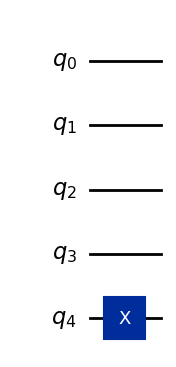

In [ ]:
## Try to run the function
dj_query(4).draw(output="mpl")

In [ ]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in the Deutsch-Jozsa algorithm.

    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.barrier()
    qc.h(range(n + 1))
    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()
    qc.h(range(n))
    qc.barrier()
    qc.measure(range(n), range(n))
    return qc

In [ ]:
def dj_algorithm(function: QuantumCircuit):
    # Determine if a function is constant or balanced.

    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

balanced


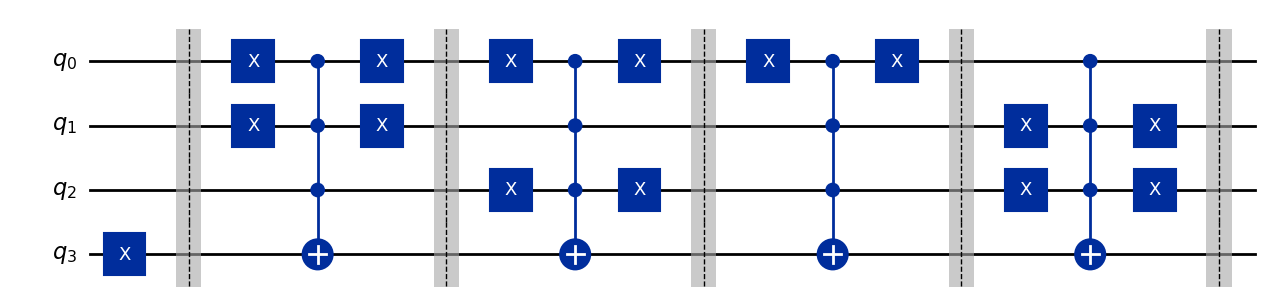

In [ ]:
f = dj_query(3)
print(dj_algorithm(f))
f.draw("mpl")


In the Deutsch-Jozsa algorithm, one convenient way to construct a **balanced function** is through the **binary dot product** between a fixed secret bitstring $s$ and the input $x$:

$$
f_s(x) = s \cdot x \pmod{2}.
$$

This mathematical definition provides an entire family of valid balanced functions—each with half of all inputs mapping to 0 and half mapping to 1.

Let both $s$ and $x$ be $n$-bit binary strings:

$$
s = (s_{n-1}, s_{n-2}, \ldots, s_0), \qquad
x = (x_{n-1}, x_{n-2}, \ldots, x_0).
$$
Then the **binary dot product** is computed as:
$$
s \cdot x = (s_{n-1}x_{n-1}) \oplus (s_{n-2}x_{n-2}) \oplus \cdots \oplus (s_0x_0),
$$
where:
- each $s_i x_i$is a logical AND (multiplication modulo 2),
- $\oplus$ denotes XOR (addition modulo 2).

The result is 1 if an **odd number** of the active bits in $s$ align with 1's in $x$, and 0 otherwise.


In circuit form, each term $s_i x_i$ corresponds to a **controlled-NOT** operation:

- When $s_i = 1$, apply `CX(i, output)` from input qubit $i$ to the output qubit.
- When $s_i = 0$, skip that control (it contributes nothing).

Multiple `CX` gates on the same output qubit naturally implement the XOR combination, since an even number of flips cancels out 0 and an odd number produces a 1.  
The resulting oracle realizes exactly the function $f_s(x)=s\cdot x \bmod 2$.

## 4. Bernstein-Vazirani Algorithm

### 4.1 Problem (Hidden String)
We are given black-box access to a Boolean function
$$
f_s(x) = s \cdot x \pmod{2} \qquad\text{with } s \in \{0,1\}^n,\ x \in \{0,1\}^n,
$$
where $s \cdot x$ is the bitwise inner product modulo 2. The task is to **recover the entire secret string $s$** using as few queries as possible. Classically, at least $n$ queries are needed (each query reveals at most one bit about $s$). Quantumly, BV finds $s$ with **one query**.

### 4.2 Oracle (Bit-Flip vs Phase)
As in Deutsch-Jozsa, we use a **bit-flip oracle**
$$
U_f: |x\rangle|y\rangle \mapsto |x\rangle\,|y \oplus f_s(x)\rangle,
$$
and prepare the output qubit in $|-\rangle=(|0\rangle-|1\rangle)/\sqrt{2}$. This converts $U_f$ into an effective **phase oracle** on the input:
$$
U_f\big(|x\rangle\otimes|-\rangle\big) = (-1)^{f_s(x)}|x\rangle\otimes|-\rangle
= (-1)^{s\cdot x}|x\rangle\otimes|-\rangle.
$$
Thus the function value becomes a **phase** depending on $s\cdot x$.

### 4.3 Circuit
1. Initialize $|0\rangle^{\otimes n}|1\rangle$.
2. Apply $H^{\otimes (n+1)}$ to create $\frac{1}{\sqrt{2^{n}}}\sum_x |x\rangle \otimes |-\rangle$.
3. Query $U_f$ once to imprint phases $(-1)^{s\cdot x}$ on the input superposition.
4. Apply $H^{\otimes n}$ to the input register.
5. Measure the input register: **the outcome is exactly the bit-string \(s\)**.

Similar to Deutsch-Jozsa, we will just focus on step 3 in creating $U_f$ since the other steps have similar implementation as the other oracle-based query algorithms.


In [ ]:
def bv_query(s):
    '''
    This implementation is adapted from IBM Quantum's Bernstein-Vazirani Lesson
    '''

    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
          qc.cx(index, len(s))
        else:
          qc.id(len(s))
    return qc


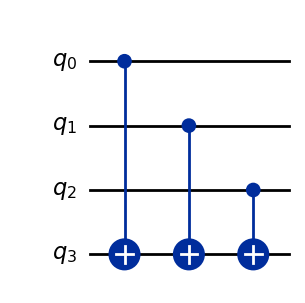

In [ ]:
display(bv_query("111").draw(output="mpl"))

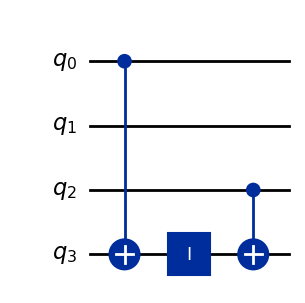

In [ ]:
display(bv_query("101").draw(output="mpl"))

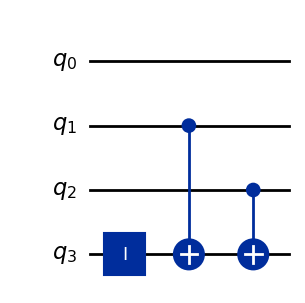

In [ ]:
display(bv_query("110").draw(output="mpl"))

In [ ]:
def bv_algorithm(function: QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    print("Bitsring:  ", result.get_memory()[0])
    return qc


Bitsring:   1011


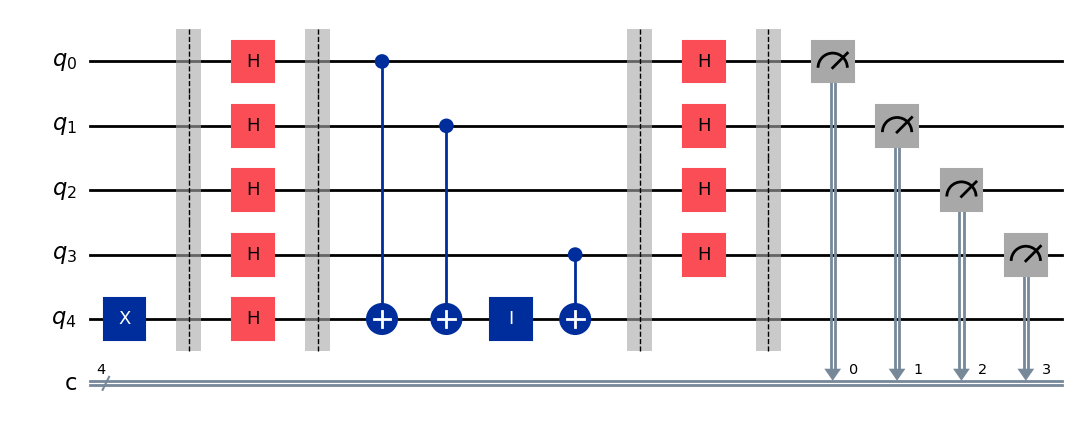

In [ ]:
display(bv_algorithm(bv_query("1011")).draw("mpl"))